# Programming Assignment: Build a CNN for image recognition.

### Name: Patrick McElroy


## 0. You will do the following:

1. Read, complete, and run the code.

2. **Make substantial improvements** to maximize the accuracy.
    
3. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain the code and the output after execution.
    
    * Missing **the output after execution** will not be graded.


4. Upload the .HTML file to your Google Drive, Dropbox, or Github repo. (If you submit the file to Google Drive or Dropbox, you must make the file "open-access". The delay caused by "deny of access" may result in late penalty.)

4. On Canvas, submit the Google Drive/Dropbox/Github link to the HTML file.


## Requirements:

1. You can use whatever CNN architecture, including VGG, Inception, and ResNet. However, you must build the networks layer by layer. You must NOT import the archetectures from ```keras.applications```.

2. Make sure ```BatchNormalization``` is between a ```Conv```/```Dense``` layer and an ```activation``` layer.

3. If you want to regularize a ```Conv```/```Dense``` layer, you should place a ```Dropout``` layer **before** the ```Conv```/```Dense``` layer.

4. An accuracy above 70% is considered reasonable. An accuracy above 80% is considered good. Without data augmentation, achieving 80% accuracy is difficult.


## Google Colab

- If you do not have GPU, the training of a CNN can be slow. Google Colab is a good option.

- Keep in mind that you must download it as an IPYNB file and then use IPython Notebook to convert it to HTML.

- Also keep in mind that the IPYNB and HTML files must contain the outputs. (Otherwise, the instructor will not be able to know the correctness and performance.) Do the followings to keep the outputs.

- In Colab, go to ```Runtime``` --> ```Change runtime type``` --> Do NOT check ```Omit code cell output when saving this notebook```. In this way, the downloaded IPYNB file contains the outputs.

## 1. Data preparation

### 1.1. Load data


In [7]:
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
import numpy

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('shape of x_train: ' + str(x_train.shape))
print('shape of y_train: ' + str(y_train.shape))
print('shape of x_test: ' + str(x_test.shape))
print('shape of y_test: ' + str(y_test.shape))
print('number of classes: ' + str(numpy.max(y_train) - numpy.min(y_train) + 1))

shape of x_train: (50000, 32, 32, 3)
shape of y_train: (50000, 1)
shape of x_test: (10000, 32, 32, 3)
shape of y_test: (10000, 1)
number of classes: 10


### 1.2. One-hot encode the labels

In the input, a label is a scalar in $\{0, 1, \cdots , 9\}$. One-hot encode transform such a scalar to a $10$-dim vector. E.g., a scalar ```y_train[j]=3``` is transformed to the vector ```y_train_vec[j]=[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]```.

1. Define a function ```to_one_hot``` that transforms an $n\times 1$ array to a $n\times 10$ matrix.

2. Apply the function to ```y_train``` and ```y_test```.

In [2]:
def to_one_hot(y, num_class=10):
    results = numpy.zeros((len(y), num_class))
    for i, yi in enumerate(y):
        results[i, yi] = 1
    return results

y_train_vec = to_one_hot(y_train)
y_test_vec = to_one_hot(y_test)

print('Shape of y_train_vec: ' + str(y_train_vec.shape))
print('Shape of y_test_vec: ' + str(y_test_vec.shape))

print(y_train[0])
print(y_train_vec[0])

Shape of y_train_vec: (50000, 10)
Shape of y_test_vec: (10000, 10)
[6]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


#### Remark: the outputs should be
* Shape of y_train_vec: (50000, 10)
* Shape of y_test_vec: (10000, 10)
* [6]
* [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]

### 1.3. Randomly partition the training set to training and validation sets

Randomly partition the 50K training samples to 2 sets:
* a training set containing 40K samples
* a validation set containing 10K samples


In [3]:
rand_indices = numpy.random.permutation(50000)
train_indices = rand_indices[0:40000]
valid_indices = rand_indices[40000:50000]

x_val = x_train[valid_indices, :]
y_val = y_train_vec[valid_indices, :]

x_tr = x_train[train_indices, :]
y_tr = y_train_vec[train_indices, :]

print('Shape of x_tr: ' + str(x_tr.shape))
print('Shape of y_tr: ' + str(y_tr.shape))
print('Shape of x_val: ' + str(x_val.shape))
print('Shape of y_val: ' + str(y_val.shape))

Shape of x_tr: (40000, 32, 32, 3)
Shape of y_tr: (40000, 10)
Shape of x_val: (10000, 32, 32, 3)
Shape of y_val: (10000, 10)


In [56]:
import numpy as np
from sklearn.decomposition import PCA

np.set_printoptions(precision=2, suppress=True)

X = x_tr.reshape(40000, 3072)
m = X.shape[0]
mu = np.mean(X, axis = 0)
S = np.dot((X-mu), (X-mu))/(m-1)

w, v = np.linalg.eig(S)

print(f"Eigenvalues: ", {w})

Explained Variance Ratio
[0.18 0.1  0.05 0.05 0.04 0.04 0.03 0.03 0.02 0.02]


In [ ]:
pca = PCA(n_components = 10)

Xpca = pca.fit_transform(X)
print ("Explained Variance Ratio")
print (pca.explained_variance_ratio_)

## 2. Build a CNN and tune its hyper-parameters

1. Build a convolutional neural network model
2. Use the validation data to tune the hyper-parameters (e.g., network structure, and optimization algorithm)
    * Do NOT use test data for hyper-parameter tuning!!!
3. Try to achieve a validation accuracy as high as possible.

### Remark: 

The following CNN is just an example. You are supposed to make **substantial improvements** such as:
* Add more layers.
* Use regularizations, e.g., dropout.
* Use batch normalization.

In [57]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, BatchNormalization, Dropout
from keras.models import Sequential

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3), name="block1_conv1"))
model.add(Conv2D(32, (3, 3), padding='same', name="block1_conv2"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), padding='same', name="block2_conv1"))
model.add(Conv2D(64, (3, 3), padding='same', name="block2_conv2"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
#model.add(Conv2D(128, (3, 3), padding='same', name="block3_conv1"))
#model.add(Conv2D(128, (3, 3), padding='same', name="block3_conv2"))
#model.add(BatchNormalization())
#model.add(Activation('relu'))
#model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 32, 32, 32)        896       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_20 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
activation_20 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 64)        18496     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 64)       

For most image recognition problems, a deep network isn't necessary. Previously I mimmicked the full VGG-16 architecture, however I found that using the first 3 convolutional blocks, the last block with only 2 convolutional layers, with the dense layer yields better results with less trainable parameters.

In [58]:
from keras import optimizers

learning_rate = 0.001 # to be tuned!

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=learning_rate),
              metrics=['acc'])

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range = 40, 
    width_shift_range = 0.2, 
    height_shift_range = 0.2, 
    shear_range = 0.2, 
    zoom_range = 0.2, 
    horizontal_flip = True,
    dtype = 'float32')

In [ ]:
train_generator = train_datagen.flow_from_directory( 
    x_train,
    target_size = (32,32,3),
    batch_size = 64,
    class_mode = 'categorical'
)

In [59]:
history = model.fit(x_tr, y_tr, batch_size=64, epochs=10, validation_data=(x_val, y_val))

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 397s 10ms/step - loss: 1.8052 - acc: 0.4096 - val_loss: 1.7768 - val_acc: 0.4279
Epoch 2/10
40000/40000 [==============================] - 414s 10ms/step - loss: 1.2080 - acc: 0.5772 - val_loss: 1.1399 - val_acc: 0.6096
Epoch 3/10
40000/40000 [==============================] - 417s 10ms/step - loss: 1.0224 - acc: 0.6461 - val_loss: 0.9964 - val_acc: 0.6562
Epoch 4/10
40000/40000 [==============================] - 471s 12ms/step - loss: 0.9260 - acc: 0.6788 - val_loss: 0.8667 - val_acc: 0.6999
Epoch 5/10
40000/40000 [==============================] - 445s 11ms/step - loss: 0.8651 - acc: 0.7005 - val_loss: 0.9177 - val_acc: 0.6861
Epoch 6/10
40000/40000 [==============================] - 449s 11ms/step - loss: 0.8180 - acc: 0.7168 - val_loss: 0.8040 - val_acc: 0.7296
Epoch 7/10
40000/40000 [==============================] - 460s 11ms/step - loss: 0.7785 - acc: 0.7310 - val_loss: 0.

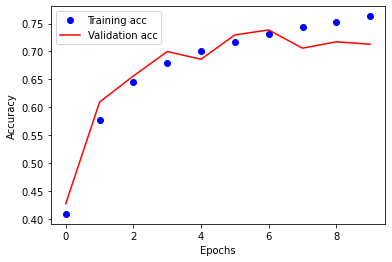

In [60]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In the above plot we can see that by the end of training, the validation set almlost matches the training accuracy with the exception of some slight fluctuation towards the end. Because of this, we can say that there is little to no overfitting in the model.

## 3. Train (again) and evaluate the model

- To this end, you have found the "best" hyper-parameters. 
- Now, fix the hyper-parameters and train the network on the entire training set (all the 50K training samples)
- Evaluate your model on the test set.

### 3.1. Train the model on the entire training set

Why? Previously, you used 40K samples for training; you wasted 10K samples for the sake of hyper-parameter tuning. Now you already know the hyper-parameters, so why not using all the 50K samples for training?

In [61]:
from keras import optimizers

learning_rate = 0.001 # to be tuned!

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=learning_rate),
              metrics=['acc'])

In [62]:
#Train your model on the entire training set (50K samples)>
#Use (x_train, y_train_vec) instead of (x_tr, y_tr)>
#Do NOT use the validation_data option (because now you do not have validation data)>

history = model.fit(x_train, y_train_vec, batch_size=64, epochs=10)

Epoch 1/10
50000/50000 [==============================] - 506s 10ms/step - loss: 0.7177 - acc: 0.7545
Epoch 2/10
50000/50000 [==============================] - 506s 10ms/step - loss: 0.6857 - acc: 0.7656
Epoch 3/10
50000/50000 [==============================] - 566s 11ms/step - loss: 0.6650 - acc: 0.7736
Epoch 4/10
50000/50000 [==============================] - 542s 11ms/step - loss: 0.6516 - acc: 0.7787
Epoch 5/10
50000/50000 [==============================] - 496s 10ms/step - loss: 0.6393 - acc: 0.7830
Epoch 6/10
50000/50000 [==============================] - 489s 10ms/step - loss: 0.6265 - acc: 0.7851
Epoch 7/10
50000/50000 [==============================] - 503s 10ms/step - loss: 0.6157 - acc: 0.7891
Epoch 8/10
50000/50000 [==============================] - 491s 10ms/step - loss: 0.6044 - acc: 0.7930
Epoch 9/10
50000/50000 [==============================] - 488s 10ms/step - loss: 0.5899 - acc: 0.7998
Epoch 10/10
50000/50000 [==============================] - 490s 10ms/step - loss: 

### 3.2. Evaluate the model on the test set

Do NOT used the test set until now. Make sure that your model parameters and hyper-parameters are independent of the test set.

In [63]:
loss_and_acc = model.evaluate(x_test, y_test_vec)
print('loss = ' + str(loss_and_acc[0]))
print('accuracy = ' + str(loss_and_acc[1]))

10000/10000 [==============================] - 31s 3ms/step
loss = 0.7993083780288697
accuracy = 0.743399977684021


After training the model on the full training set, the training accuracy is about 0.87. After evaluating the model on the test set, the accuracy is quite high with about 0.802. As stated at the top of the notebook in the instructions, this is a great accuracy considering there was no data augmentation used. This shows that a deep convolutional network isn't necessary for image classification problems, it can be done with just a few convolutional blocks and a dense layer.